## Transport-accelerated preconditioners for score-based generative modeling with SDEs (Simple examples)

In [ ]:
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim
import torch.nn as nn
import lib.toy_data as toy_data
import numpy as np

import lib.layers as layers

import argparse


Basic parameters 

In [45]:
parser = argparse.ArgumentParser('TAP-SGM')
parser.add_argument(
    '--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings'],
    type=str, default='moons'
)


parser.add_argument('--depth', help='number of layers of score network', type=int, default=8)
parser.add_argument('--hiddenunits',type = int, default = 32)
parser.add_argument('--niters', type=int, default=100001)
parser.add_argument('--batch_size', type=int, default=256)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--save', type=str, default='experiments/cnf')
parser.add_argument('--tint',type = float, default = 0.02)
parser.add_argument('--finalT',type = float, default = 0.5)


_StoreAction(option_strings=['--finalT'], dest='finalT', nargs=None, const=None, default=0.5, type=<class 'float'>, choices=None, required=False, help=None, metavar=None)

In [46]:
args = parser.parse_args('')

learning_rate = args.lr  # learning rate for training neural network
batch_size = args.batch_size  # batch size during training of neural network
epochs = args.niters   # Number of training epochs for the neural network
tint = args.tint #  put more points in the initial training
T = args.finalT    # Forward simulation time in the forward SDE
dataset = args.data # Dataset choice, see toy_data for full options of toy datasets ('checkerboard','8gaussians','2spirals','swissroll','moons',etc.)
saveloc = args.save # save folder



Load preconditioning map

In [47]:
def construct_model():

    if preconditionerargs.nf:
        chain = []
        for i in range(preconditionerargs.depth):
            chain.append(layers.PlanarFlow(2))
        return layers.SequentialFlow(chain)
    else:
        chain = []
        for i in range(preconditionerargs.depth):
            if preconditionerargs.glow: chain.append(layers.BruteForceLayer(2))
            chain.append(layers.CouplingLayer(2, swap=i % 2 == 0))
        return layers.SequentialFlow(chain)
    
checkpointlocation = 'experiments/cnf/'+dataset+'_depth3/checkpt.pth' 
checkpoint = torch.load(checkpointlocation)
preconditionerargs = checkpoint['args']
model = construct_model()
model.load_state_dict(checkpoint['state_dict'])




<All keys matched successfully>

We first initialize the neural net that models the score function. A key part of this is that we train adaptive Fourier features

In [126]:
# Bespoke activation function
class cosineact(nn.Module):
    def __init__(self,weights = 1):
        super().__init__()
        self.weights = weights

    def forward(self,input):
        evaluation = torch.cos(self.weights * input)
        return evaluation


# Random Fourier features
B = 2*torch.pi/ 3 * torch.randn(2,int(args.hiddenunits))
c = 2 *torch.pi/3 * torch.rand(1,int(args.hiddenunits))



In [127]:
## Score Model construction
def construct_score_model(depth,hidden_units):
    chain = []
    chain.append(nn.Linear(int(hidden_units)+1,int(hidden_units),bias =True))
    chain.append(nn.GELU())

    for ii in range(depth-1):
        chain.append(nn.Linear(int(hidden_units),int(hidden_units),bias = True))
        chain.append(nn.GELU())
    chain.append(nn.Linear(int(hidden_units),2,bias = True))    

    return nn.Sequential(*chain)



      
scorenet = construct_score_model(args.depth,args.hiddenunits)
print(scorenet)
optimizer = optim.Adam(scorenet.parameters(), lr=learning_rate)

Sequential(
  (0): Linear(in_features=65, out_features=32, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): GELU(approximate='none')
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): GELU(approximate='none')
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=32, bias=True)
  (9): GELU(approximate='none')
  (10): Linear(in_features=32, out_features=32, bias=True)
  (11): GELU(approximate='none')
  (12): Linear(in_features=32, out_features=32, bias=True)
  (13): GELU(approximate='none')
  (14): Linear(in_features=32, out_features=32, bias=True)
  (15): GELU(approximate='none')
  (16): Linear(in_features=32, out_features=2, bias=True)
)


Define loss functions. These loss functions assume that the forward process is a standard OU process dx = -x/2 dt + dW. The choice of \lambda(t) in the SGM objective function is equal to 1 (the constant in front of the dW term). 

In [128]:
# Loss function -- we use the denoising diffusions objective function
# Scorenet is the score model, samples are the training samples, Tmin/Tmax are the time interval that is being trained on, and eps is so that Tmin is not sampled. 

def time_dsm_score_estimator(scorenet,samples,Tmin,Tmax,eps):

    t = torch.rand(samples.shape[0]) * (Tmax - Tmin - eps) + eps + Tmin # sample uniformly from time interval

    # Add noise to the training samples
    sigmas = torch.sqrt(1 - torch.exp(-t))
    sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
    noise = torch.randn_like(samples) * sigmas
    tenlarge = t.repeat(2,1).T
    perturbed_samples = samples * torch.exp(-0.5 * tenlarge) + noise

    # Evaluate score and marginal score on the perturbed samples
    target = - 1/ (sigmas ** 2) * (noise)
    score_eval_samples = torch.cat((t.reshape(-1,1),perturbed_samples),1)
    scores = -perturbed_samples + scorenet(score_eval_samples)

    # Evaluate the loss function 
    target = target.view(target.shape[0],-1)
    scores = scores.view(scores.shape[0],-1)
    loss = 0.5 * ((scores-target) ** 2).sum(dim = -1) 

    return loss.mean(dim = 0)


def FF_time_dsm_score_estimator(scorenet,samples,Tmin,Tmax,eps,B,c):

    t = torch.rand(samples.shape[0]) * (Tmax - Tmin - eps) + eps + Tmin


    sigmas = torch.sqrt(1 - torch.exp(-t))
    sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
    noise = torch.randn_like(samples) * sigmas
    tenlarge = t.repeat(2,1).T
    perturbed_samples = samples * torch.exp(-0.5 * tenlarge) + noise
    target = - 1/ (sigmas ** 2) * (noise)

    checkbounds = (torch.abs(samples[:,0])<3).type(torch.uint8) * (torch.abs(samples[:,1])<3)

    FFperturbed_samples = torch.matmul(perturbed_samples,B) + c 
    # perturbed_samples = torch.cat( (torch.cos(FFperturbed_samples), torch.sin(FFperturbed_samples)),1 )

    FFperturbed_samples = torch.multiply( checkbounds.reshape(-1,1) , torch.cos(FFperturbed_samples) )

    score_eval_samples = torch.cat((t.reshape(-1,1),FFperturbed_samples),1)
    scores = -perturbed_samples + scorenet(score_eval_samples)

    target = target.view(target.shape[0],-1)
    scores = scores.view(scores.shape[0],-1)
    loss = 0.5 * ((scores-target) ** 2).sum(dim = -1) 

    return loss.mean(dim = 0)


# Loss function
# This is for if you have a specific mesh for the time interval you would like the network to train on. 
def deterministic_time_dsm_score_estimator(scorenet,samples,t):

    loss = 0
    for ii in range(len(t)-1):

        # Add noise to the training samples
        sigmas = torch.sqrt(1 - torch.exp(-t[ii]))
        noise = torch.randn_like(samples) * sigmas
        perturbed_samples = samples * torch.exp(-0.5 * t[ii]) + noise

        # Evaluate score and marginal score on perturbed samples
        target = - 1/ (sigmas ** 2) * (noise)
        score_eval_samples = torch.cat((t[ii].repeat(perturbed_samples.shape[0],1),perturbed_samples),1)
        scores = scorenet(score_eval_samples)

        # Evaluate loss function at this particular t[ii]
        target = target.view(target.shape[0],-1)
        scores = scores.view(scores.shape[0],-1)
        loss_vec = 0.5 * ((scores-target) ** 2).sum(dim = -1) 
        loss = loss + (t[ii+1]-t[ii])*loss_vec.mean(dim = 0)

    return loss


Training the score network

In [129]:
# Training the score network

for step in range(epochs):
    # sample toy_data
    p_samples = toy_data.inf_train_gen(dataset, batch_size = batch_size)
    samples = torch.tensor(p_samples).to(dtype = torch.float32)
    samples = model(samples,None,reverse = False) 


    half = int(batch_size/2)
    samples1 = samples[0:half,:]
    samples2 = samples[half:-1,:]
    # evaluate loss function and gradient
    # loss = time_dsm_score_estimator(scorenet,samples,0,T,eps = 0.0005)
    # loss = time_dsm_score_estimator(scorenet,samples1,0,tint,0.0001) + time_dsm_score_estimator(scorenet,samples2,tint,T,0.0001)
    loss = FF_time_dsm_score_estimator(scorenet,samples1,0,tint,0.0001,B,c) + FF_time_dsm_score_estimator(scorenet,samples2,tint,T,0.0001,B,c)

    optimizer.zero_grad()
    loss.backward()

    # Update score network
    optimizer.step()

    if not step%100:
        print(loss,step)




tensor(316.3563, grad_fn=<AddBackward0>) 0
tensor(186.2819, grad_fn=<AddBackward0>) 100
tensor(281.8244, grad_fn=<AddBackward0>) 200
tensor(256.1424, grad_fn=<AddBackward0>) 300
tensor(323.9405, grad_fn=<AddBackward0>) 400
tensor(346.0876, grad_fn=<AddBackward0>) 500
tensor(214.4970, grad_fn=<AddBackward0>) 600
tensor(269.4547, grad_fn=<AddBackward0>) 700
tensor(178.6403, grad_fn=<AddBackward0>) 800
tensor(219.5131, grad_fn=<AddBackward0>) 900
tensor(205.2012, grad_fn=<AddBackward0>) 1000
tensor(339.9064, grad_fn=<AddBackward0>) 1100
tensor(229.1267, grad_fn=<AddBackward0>) 1200
tensor(220.2371, grad_fn=<AddBackward0>) 1300
tensor(288.8006, grad_fn=<AddBackward0>) 1400
tensor(165.5218, grad_fn=<AddBackward0>) 1500
tensor(208.0432, grad_fn=<AddBackward0>) 1600
tensor(151.4457, grad_fn=<AddBackward0>) 1700
tensor(456.5043, grad_fn=<AddBackward0>) 1800
tensor(391.6392, grad_fn=<AddBackward0>) 1900
tensor(224.5510, grad_fn=<AddBackward0>) 2000
tensor(187.9685, grad_fn=<AddBackward0>) 2100


SDE simulation functions

In [138]:
# This is the solving the OU process exactly given deterministic initial conditions
def ou_dynamics(init, T):
    init = init * torch.exp(- 0.5 * T) + torch.sqrt(1-torch.exp(-T)) * torch.randn_like(init)
    return init

def reverse_sde(score, init,T,lr=0.0005):
    step = int(T/lr) 
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + score(evalpoint).detach() )
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init


# The following is the deterministic ODE flow that can also sample from the target distribution

def reverse_ode_flow(score,init,T,lr = 0.0005):
    step = int(T/lr)
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + 1/2 * score(evalpoint).detach() )
    return init



def FF_reverse_sde(score, init,T,B,c,lr=0.0001):
    step = int(T/lr) 
    for i in range(step,-1,-1):
        current_lr = lr


        FFinit = torch.matmul(init,B) + c
        checkbounds = (torch.abs(init[:,0])<3).type(torch.uint8) * (torch.abs(init[:,1])<3)
        FFinit = torch.multiply( checkbounds.reshape(-1,1) , torch.cos(FFinit) )
        
        # FFinit = torch.cat( (torch.cos(FFinit), torch.sin(FFinit)),1 )
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(FFinit.shape[0],1),FFinit),1)


        init = init + current_lr  * (init/2 +( -init + score(evalpoint).detach() ))
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init


def FF_reverse_ode_flow(score,init,T,B,c,lr = 0.0001):
    step = int(T/lr)
    for i in range(step,-1,-1):
        current_lr = lr

        FFinit = torch.matmul(init,B) + c
        checkbounds = (torch.abs(init[:,0])<3).type(torch.uint8) * (torch.abs(init[:,1])<3)
        FFinit = torch.multiply( checkbounds.reshape(-1,1) , torch.cos(FFinit) )
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(FFinit.shape[0],1),FFinit),1)
        init = init + current_lr  * (init/2 + 1/2 *( - init +  score(evalpoint).detach()) )
    return init

Sample using the score network 

In [139]:
# Denoising the normal distribution 
samples_lang = torch.randn(10000, 2) # * (right_bound - left_bound) + left_bound
# samples_lang = reverse_sde(scorenet, samples_lang,torch.tensor(T)).detach().numpy()
samples_lang = FF_reverse_sde(scorenet, samples_lang,torch.tensor(T),B,c).detach().numpy()

# Denoising samples from the training data
samples = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 10000))
samples = model(samples.to(dtype = torch.float32),None,reverse = False)
samples_lang_noisedtraining = samples * torch.exp(-0.5 * torch.tensor(T)) + torch.sqrt(1-torch.exp(-torch.tensor(T))) * torch.randn_like(samples)
# samples_lang_noisedtraining =reverse_sde(scorenet, samples_lang_noisedtraining.to(dtype=torch.float32),torch.tensor(T)).detach().numpy()
samples_lang_noisedtraining =FF_reverse_sde(scorenet, samples_lang_noisedtraining.to(dtype=torch.float32),torch.tensor(T),B,c).detach().numpy()

# Deterministically evolving the normal distribution 
samples_deterministic = torch.randn(10000,2)
# samples_deterministic = reverse_ode_flow(scorenet,samples_deterministic,torch.tensor(T)).detach().numpy()
samples_deterministic = FF_reverse_ode_flow(scorenet,samples_deterministic,torch.tensor(T),B,c).detach().numpy()

Postprocessing with the map

In [140]:
samples_lang_target = model(torch.tensor(samples_lang),None,reverse = True).detach().numpy()
samples_lang_noisedtraining_target = model(torch.tensor(samples_lang_noisedtraining),None,reverse = True).detach().numpy()
samples_deterministic_target = model(torch.tensor(samples_deterministic),None,reverse = True).detach().numpy()


Make and save plots

<Figure size 640x480 with 0 Axes>

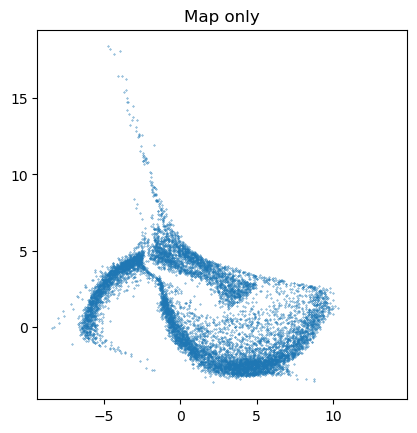

In [141]:
savedir = saveloc + '/' + dataset + '_precdepth3_scoredepth' + str(args.depth)+'_tapsgm_FFtest_deeperpreprocess/'

# Check whether the specified path exists or not
isExist = os.path.exists(savedir)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(savedir)







plt.clf()
p_samples = toy_data.inf_train_gen(dataset, batch_size = 10000)
samples_true = torch.tensor(p_samples).to(dtype = torch.float32)
plt.scatter(samples_true[:,0],samples_true[:,1],s = 0.1)
plt.axis('square')
plt.title('True samples')


savename = savedir + 'true_samples.png'
plt.savefig(savename)




plt.clf()
pushforward_samples_true = model(samples_true,None,reverse = False).detach().numpy()
plt.scatter(pushforward_samples_true[:,0],pushforward_samples_true[:,1],s = 0.1)
plt.axis('square')
plt.title('True pushforward samples')

savename = savedir + 'true_pushforward.png'
plt.savefig(savename)


# plt.clf()
# pushforward_samples_true = model(samples_true,None,reverse = False).detach().numpy()
# pushforward_samples_atT = ou_dynamics(torch.tensor(pushforward_samples_true),torch.tensor(T)).detach().numpy()
# plt.scatter(pushforward_samples_atT[:,0],pushforward_samples_atT[:,1],s = 0.1)
# plt.axis('square')
# plt.title('True pushforward samples at T')

# savename = savedir + 'true_pushforward_atT.png'
# plt.savefig(savename)

plt.clf()

fig,axs = plt.subplots(1,6)
samples_nf = model(samples_true,None,reverse = False)

for jj in range(6):

    samples_nf_out = ou_dynamics(samples_nf,torch.tensor(T/6*jj)).detach().numpy()
    axs[jj].set_box_aspect(1)
    axs[jj].set_xlim([-6, 6])
    axs[jj].set_ylim([-6, 6])
    axs[jj].scatter(samples_nf_out[:,0],samples_nf_out[:,1],s = 0.1)

# plt.title('True pushforward samples at T')
savename = savedir + 'true_pushforward_atT.png'
plt.savefig(savename)




plt.clf()
plt.scatter(samples_lang[:,0],samples_lang[:,1],s = 0.1)
plt.axis('square')
plt.title('Reverse SDE pushforward')
savename = savedir + 'reversesde_pushforward.png'
plt.savefig(savename)




plt.clf()
plt.scatter(samples_lang_target[:,0],samples_lang_target[:,1],s = 0.1)
plt.axis('square')
plt.title('Denoising normal distribution')
savename = savedir + 'reversesde_target.png'
plt.savefig(savename)



plt.clf()
plt.scatter(samples_lang_noisedtraining_target[:,0],samples_lang_noisedtraining_target[:,1],s = 0.1)
plt.axis('square')
plt.title('Denoising noised training samples')
savename = savedir + 'reversesde_noisedtraining_target.png'
plt.savefig(savename)



plt.clf()
plt.scatter(samples_deterministic_target[:,0],samples_deterministic_target[:,1],s = 0.1)
plt.axis('square')
plt.title('Denoising normal with ODE flow')
savename = savedir + 'deterministic_ode_target.png'
plt.savefig(savename)



samples_nf = model(torch.randn(10000,2),None,reverse = True).detach().numpy()
plt.clf()
plt.scatter(samples_nf[:,0],samples_nf[:,1],s = 0.1)
plt.axis('square')
plt.title('Map only')
savename = savedir + 'map_only.png'
plt.savefig(savename)
